TensorFlow-GPU Version: 2.8.0
Begin Time: 2023-12-10 14:51:41.645445
GAN Model Running for the Ticker- 0 : UNH
epoch 181 d_loss 1.3862993 g_loss 0.6928786
epoch 182 d_loss 1.3862988 g_loss 0.6929016
epoch 183 d_loss 1.3862982 g_loss 0.69293547
epoch 184 d_loss 1.3862977 g_loss 0.6929788
epoch 185 d_loss 1.3862977 g_loss 0.6930294
epoch 186 d_loss 1.3862976 g_loss 0.6930832
epoch 187 d_loss 1.3862978 g_loss 0.6931377
epoch 188 d_loss 1.3862984 g_loss 0.6931885
epoch 189 d_loss 1.3862989 g_loss 0.6932314
epoch 190 d_loss 1.3862996 g_loss 0.6932605
epoch 191 d_loss 1.3862997 g_loss 0.69327295
epoch 192 d_loss 1.3862991 g_loss 0.69326454
epoch 193 d_loss 1.3862982 g_loss 0.6932368
epoch 194 d_loss 1.3862966 g_loss 0.6931914
epoch 195 d_loss 1.3862957 g_loss 0.6931285
epoch 196 d_loss 1.3862959 g_loss 0.6930547
epoch 197 d_loss 1.386297 g_loss 0.6929755
epoch 198 d_loss 1.3862982 g_loss 0.692901
epoch 199 d_loss 1.386299 g_loss 0.6928366
epoch 200 d_loss 1.3862993 g_loss 0.6927895


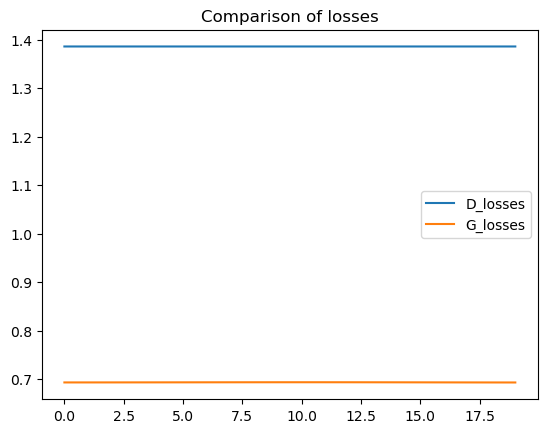

best_epoch 194
Results Saved to CSV File 
RMSE 15.29246881288064
MAPE 2.916081320019317


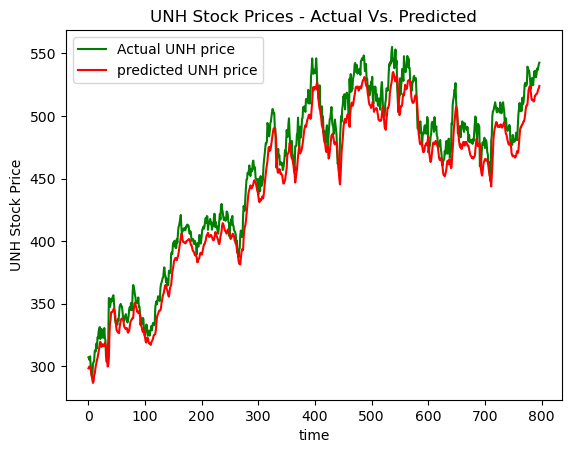

GAN Model Completed for the Ticker- 0 : UNH
Accuracy Metrics Saved to CSV File 
GAN Model Running for the Ticker- 1 : NI
epoch 181 d_loss 1.386308 g_loss 0.69322187
epoch 182 d_loss 1.3863077 g_loss 0.6932199
epoch 183 d_loss 1.3863075 g_loss 0.69321775
epoch 184 d_loss 1.3863075 g_loss 0.6932154
epoch 185 d_loss 1.3863074 g_loss 0.6932165
epoch 186 d_loss 1.3863072 g_loss 0.6932205
epoch 187 d_loss 1.3863069 g_loss 0.69322395
epoch 188 d_loss 1.3863064 g_loss 0.69322777
epoch 189 d_loss 1.386306 g_loss 0.69322896
epoch 190 d_loss 1.3863056 g_loss 0.69322526
epoch 191 d_loss 1.3863058 g_loss 0.6932204
epoch 192 d_loss 1.3863062 g_loss 0.6932115
epoch 193 d_loss 1.3863064 g_loss 0.6932037
epoch 194 d_loss 1.3863065 g_loss 0.693197
epoch 195 d_loss 1.3863063 g_loss 0.6931913
epoch 196 d_loss 1.3863058 g_loss 0.6931882
epoch 197 d_loss 1.3863051 g_loss 0.6931891
epoch 198 d_loss 1.3863041 g_loss 0.69318926
epoch 199 d_loss 1.3863031 g_loss 0.69318265
epoch 200 d_loss 1.3863033 g_loss 0.69

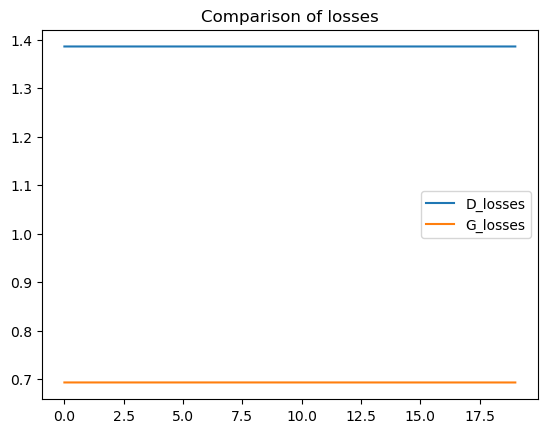

best_epoch 198
Results Saved to CSV File 
RMSE 0.6141672189202998
MAPE 1.7971421716262654


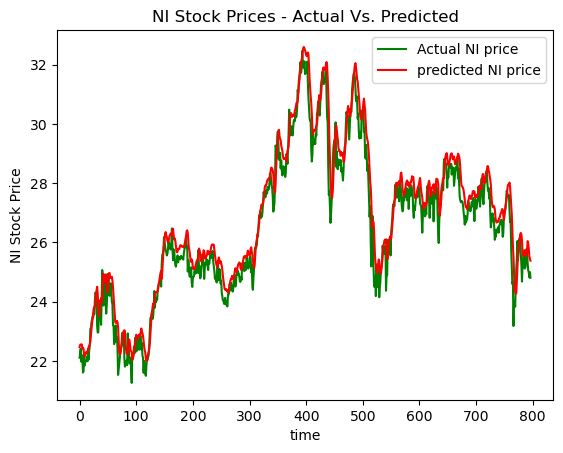

GAN Model Completed for the Ticker- 1 : NI
Accuracy Metrics Saved to CSV File 
GAN Model Running for the Ticker- 2 : ATO


In [ ]:
import time
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten, Conv1D, Dropout, Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from datetime import datetime, timedelta
import math
import warnings
print("TensorFlow-GPU Version:", tf.__version__)
begin_time = datetime.now()
print("Begin Time:", begin_time)


ticker_list = ['UNH','NI','ATO','COST','FAST']

num_tickers = len(ticker_list)

d = {'Ticker': ['' for _ in range(num_tickers)], 'RMSE': ['' for _ in range(num_tickers)], 
     'MAPE': ['' for _ in range(num_tickers)]}
df_out = pd.DataFrame(data=d)

warnings.filterwarnings("ignore")
for n in range(num_tickers): 

    ticker = ticker_list[n]
    df = pd.read_csv('./input/' + ticker + '.csv')
    print("GAN Model Running for the Ticker-",n, ":", ticker)

    datetime_series = pd.to_datetime(df['Date'])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df = df.set_index(datetime_index)
    df = df.sort_values(by='Date')
    df = df.drop(columns='Date')

    X_value = pd.DataFrame(df.iloc[:, 0:4])
    y_value = pd.DataFrame(df.iloc[:, 3])

    X_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaler.fit(X_value)
    y_scaler.fit(y_value)

    X_scale_dataset = X_scaler.fit_transform(X_value)
    y_scale_dataset = y_scaler.fit_transform(y_value)
    y_scale_dataset_inv = y_scaler.inverse_transform(y_scale_dataset)

    n_steps_in = 10
    n_features = X_value.shape[1]
    n_steps_out = 1

    def get_X_y(X_data, y_data):
        X = list()
        y = list()
        z = list()

        length = len(X_data)
        for i in range(0, length, 1):
            X_value = X_data[i: i + n_steps_in][:, :]
            y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
            z_value = y_data[i: i + n_steps_in][:, :]
            if len(X_value) == n_steps_in and len(y_value) == n_steps_out:
                X.append(X_value)
                y.append(y_value)
                z.append(z_value)

        return np.array(X), np.array(y), np.array(z)

    def split_train_test(data):
        train_size = round(len(data) * 0.8)
        data_train = data[0:train_size]
        data_test = data[train_size:]
        return data_train, data_test

    X, y, z = get_X_y(X_scale_dataset, y_scale_dataset)
    X_train, X_test, = split_train_test(X)
    y_train, y_test, = split_train_test(y)
    z_train, z_test, = split_train_test(z)
 
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epochs = 200
    
    def create_generator_model():
        gen_model = Sequential()
        gen_model.add(GRU(units = 1024, activation = 'tanh', input_shape = (input_dim, feature_size)))
        gen_model.add(Dense(512))
        gen_model.add(Dense(256))
        gen_model.add(Dense(128))
        gen_model.add(Dense(64))
        gen_model.add(Dense(units=output_dim))
        return gen_model

    def create_discriminator_model():
        disc_model = Sequential()
        disc_model.add(Conv1D(32, input_shape=(n_steps_in+1, 1), kernel_size=5, strides=2, padding='same', 
                              activation='relu'))
        disc_model.add(Dense(230, use_bias=False, activation='relu'))
        disc_model.add(Dense(220, use_bias=False, activation='relu'))
        disc_model.add(Dense(1, activation='sigmoid'))
        return disc_model

    class GAN:
        def __init__(self, generator, discriminator):
            self.generator = generator
            self.discriminator = discriminator
            self.cross_entropy = BinaryCrossentropy(from_logits=True)
            self.generator_optimizer = Adam(lr=0.00016)
            self.discriminator_optimizer = Adam(lr=0.00016)
            self.batch_size = 130
            self.checkpoint_dir = './training_checkpoints'
            self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "checkpoint")
            self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                                  discriminator_optimizer=self.discriminator_optimizer,
                                                  generator=self.generator,
                                                  discriminator=self.discriminator)

        def discriminator_loss(self, real_output, gen_output):
            real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
            gen_loss = self.cross_entropy(tf.zeros_like(gen_output), gen_output)
            total_loss = real_loss + gen_loss
            return total_loss

        def generator_loss(self, gen_output):
            return self.cross_entropy(tf.ones_like(gen_output), gen_output)
        
        @tf.function
        def train_step(self, real_x, real_y, z):
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                gen_data = self.generator(real_x, training=True)
                gen_data_reshape = tf.reshape(gen_data, [gen_data.shape[0], gen_data.shape[1], 1])
                gen_input = tf.concat([tf.cast(gen_data_reshape, tf.float64), z], axis=1)
                real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
                real_input = tf.concat([real_y_reshape, z], axis=1)
                real_output = self.discriminator(real_input, training=True)
                gen_output = self.discriminator(gen_input, training=True)
                gen_loss = self.generator_loss(gen_output)
                disc_loss = self.discriminator_loss(real_output, gen_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(gradients_of_discriminator, self.discriminator.trainable_variables))
            return real_y, gen_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

        def train(self, real_x, real_y, z):
            G_losses = []
            D_losses = []

            for epoch in range(epochs):
                real_price, gen_price, loss = self.train_step(real_x, real_y, z)

                if(epoch + 1) > 180:
                    tf.keras.models.save_model(generator, 'gen_gan_model_%d.h5' % (epoch+1))
                    self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                    print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
                    D_losses.append(loss['d_loss'].numpy())
                    G_losses.append(loss['g_loss'].numpy())
            #lowest disc loss after 180th epoch
            loss_series = pd.Series(D_losses)
            g_loss_series = pd.Series(G_losses)
            
            plt.figure()

            plt.plot(loss_series, label='D_losses')
            plt.plot(g_loss_series, label='G_losses')

            plt.title('Comparison of losses')
            plt.legend()
            plt.show()

            min_loss_index = loss_series.idxmin()
            return 180 + min_loss_index

    generator = create_generator_model()
    discriminator = create_discriminator_model()
    gan = GAN(generator, discriminator)
    best_epoch = gan.train(X_train, y_train, z_train)
    print("best_epoch", best_epoch)
    gan_model = tf.keras.models.load_model('gen_gan_model_%d.h5' % (best_epoch))
    gan_model.compile(optimizer='adam', loss='mse')
    predicted_prices_test = gan_model(X_test)
    actual_prices = y_scaler.inverse_transform(y_test)
    predicted_prices = y_scaler.inverse_transform(predicted_prices_test)
   
    out_len = len(y_test)

    doc = {'Date': ['' for _ in range(out_len)], 'Actual Input Price': ['' for _ in range(out_len)], 'Predctited Price': ['' for _ in range(out_len)]}
    df_out_compare = pd.DataFrame(data=doc)

    for p in range(out_len):
        df_out_compare.at[p,'Date'] = datetime_series[(len(datetime_series)-len(y_test))+p]
        df_out_compare.at[p,'Actual Input Price'] = actual_prices[p][0]
        df_out_compare.at[p,'Predctited Price'] = predicted_prices[p][0]

    print("Results Saved to CSV File ")
    df_out_compare.to_csv('./output/GAN/' + ticker + '_GAN_Output_Compare.csv')

    mse = tf.keras.losses.mean_squared_error(actual_prices[:,0], predicted_prices[:,0]).numpy()
    rmse =  math.sqrt(mse)
    print('RMSE', rmse)
    mape  = tf.keras.losses.mean_absolute_percentage_error(actual_prices[:,0], predicted_prices[:,0]).numpy()
    print('MAPE', mape)

    df_out.at[n,'Ticker'] = ticker
    df_out.at[n,'RMSE'] = rmse
    df_out.at[n,'MAPE'] = mape

    plt.plot(actual_prices, color='green', label=f"Actual {ticker} price")
    plt.plot(predicted_prices, color= 'red', label=f"predicted {ticker} price")
    plt.title(f"{ticker} Stock Prices - Actual Vs. Predicted")
    plt.xlabel("time")
    plt.ylabel(f"{ticker} Stock Price")
    plt.legend()
    plt.show()

    print("GAN Model Completed for the Ticker-",n, ":", ticker)
    
    df_out.to_csv('./output/GAN/TS_GAN_Accuracy_Metrics.csv')
    print("Accuracy Metrics Saved to CSV File ")

    
end_time = datetime.now()
print("End Time:", end_time)
print("Total Time Consumed:", (end_time - begin_time))
    